In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

### Data import

In [2]:
dataset_name = "SAS_1"
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
data_dir = parent_path + "/dataset/" + dataset_name
data = pd.read_sas(data_dir + '/a_eendpt.sas7bdat', format="sas7bdat")
# keep_columns = [col for col in data.columns.values if 'HGB' not in col]
keep_columns = ['PFSDY', 'PFSCD', 'DTHDY', 'DTH', 'TXGROUP', 'SEX', 'AGE', 'B_WGTN', 'B_ECOGN', 'B_LDHN', 'B_HGB', 'BSEPON', 'MEDHINTN', 'PRTFN']
# data = data[keep_columns].dropna()
data = data[keep_columns]
data = data[data['PFSDY'] <= data['DTHDY']]
data = data.drop(['DTH', 'DTHDY'] , axis=1)
keep_columns = data.columns.values

### Data preprocessing

In [3]:
# Handle missing data
for col in keep_columns:
    if col not in ["TXGROUP", "PFSDY", "PFSCD"]:
        if len(np.unique(data[col].values)) > 20:
            data[col].fillna(data[col].mean(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)
data = data[keep_columns].dropna()

In [4]:
data.shape

(478, 12)

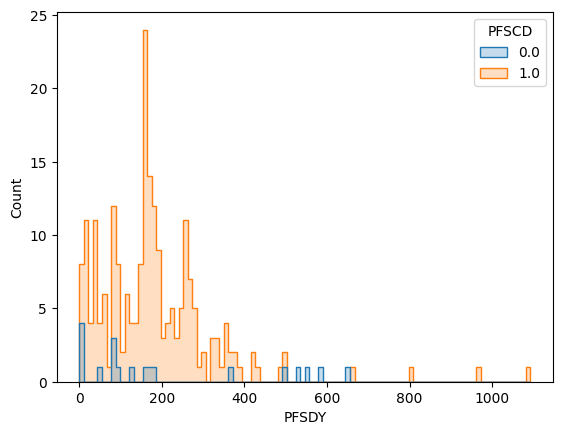

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=data[data["TXGROUP"] == b'PLACEBO'] , x="PFSDY", hue="PFSCD", bins=100, element="step", stat="count", common_bins=True)
plt.show()

In [6]:
data = data[data["PFSDY"] < 700] 

In [7]:
# Encode the features
for col in keep_columns:
    if col not in ["TXGROUP", "PFSDY", "PFSCD"]:
    # if col not in ["overall_survival_months", "overall_survival", "chemotherapy", "age_at_diagnosis"]:
        unique_value = np.unique(data[col].values)

        # Create a mapping dictionary
        mapping = dict(zip(unique_value, np.arange(len(unique_value))))

        # Replace values in the column
        data[col] = data[col].replace(mapping)

### Data types

In [8]:
data_types = [["name", "type", "dim", "nclass"], ["survcens", "surv_piecewise", 2, np.nan]]
for col in keep_columns:
    if col not in ["TXGROUP", "PFSDY", "PFSCD"]:
        n_unique = len(np.unique(data[col].values))
        if n_unique < 20:
            data_types.append([col, "cat", 1, n_unique])
        else:
            if (data[col] > 0).all():
                data_types.append([col, "pos", 1, np.nan])
            else:
                data_types.append([col, "real", 1, np.nan])

In [9]:
data_types

[['name', 'type', 'dim', 'nclass'],
 ['survcens', 'surv_piecewise', 2, nan],
 ['SEX', 'cat', 1, 2],
 ['AGE', 'real', 1, nan],
 ['B_WGTN', 'cat', 1, 2],
 ['B_ECOGN', 'cat', 1, 2],
 ['B_LDHN', 'cat', 1, 2],
 ['B_HGB', 'real', 1, nan],
 ['BSEPON', 'cat', 1, 2],
 ['MEDHINTN', 'cat', 1, 2],
 ['PRTFN', 'cat', 1, 2]]

### Split data into treated and control group

In [10]:
np.unique(data["TXGROUP"].values)

array([b'NESP', b'PLACEBO'], dtype=object)

In [11]:
data = data.rename(columns={"PFSDY": "time", "PFSCD": "censor"})
data_treated = data[data['TXGROUP']==b'NESP'].drop(['TXGROUP'] , axis=1)
data_control = data[data['TXGROUP']==b'PLACEBO'].drop(['TXGROUP'] , axis=1)

In [12]:
data_control.shape

(236, 11)

### Save data

In [13]:
import csv

data.to_csv(data_dir + "/data.csv", header=False, index=False)
data_treated.to_csv(data_dir + "/data_treated.csv", header=False, index=False)
data_control.to_csv(data_dir + "/data_control.csv", header=False, index=False)
pd.DataFrame(data_types).to_csv(data_dir + "/data_types_treated.csv", index=False, header=False)
pd.DataFrame(data_types).to_csv(data_dir + "/data_types_control.csv", index=False, header=False)